In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

import sys
sys.path.append("..")
from models.lstm import DeepTCNLSTMAttention
from data_setup import SHHSDataset
from config import LSTMConfig

In [2]:
model_path = "../checkpoints/best_shhs_ecg_model.pt"
model = DeepTCNLSTMAttention(
    num_features=LSTMConfig.NUM_RESHAED_FEATURES,
    feature_channels=LSTMConfig.FEATURE_CHANNELS,
    num_channels=LSTMConfig.NUM_CHANNELS,
    kernel_size=LSTMConfig.KERNEL_SIZE,
    hidden_dim=LSTMConfig.HIDDEN_DIM,
    num_heads=LSTMConfig.NUM_HEADS,
    num_layers=LSTMConfig.NUM_LAYERS,
    num_classes=3,
    tcn_layers=LSTMConfig.TCN_LAYERS
)
model.load_state_dict(torch.load(model_path))
model.eval()

DeepTCNLSTMAttention(
  (feature_extractor): DeepFeatureExtractor(
    (layers): Sequential(
      (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): ReLU(inplace=True)
      (2): ResBlock(
        (conv1): Conv1d(16, 32, kernel_size=(3,), stride=(4,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (dropout2): Dropout(p=0.2, inplace=False)
        (downsample): Sequential(
          (0): Conv1d(16, 32, kernel_size=(1,), stride=(4,), bias=False)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (3): ResBlock(
     

In [1]:
#DATASET = "SHHS"
DATASET = "DREAMT"

root_dir = Path("/media/nvme1/sleep/ECG")
ecg_dir = root_dir / DATASET
dataset = DATASET.lower() + "_ecg"
if DATASET == "DREAMT":
    downsampling_rate = 4
else:
    downsampling_rate = 5

dataset = SHHSDataset(dir=ecg_dir, dataset=dataset, multiplier=1e6, downsample_rate=downsampling_rate, return_file_name=True)

NameError: name 'Path' is not defined

## Night-level (hypnogram) Comparison

In [1118]:
# Select a random sample from the dataset
random_idx = random.randint(0, len(dataset) - 1)
ecg, labels, lengths, subject = dataset[random_idx]
lengths = torch.tensor([lengths], dtype=torch.int64)
input_tensor = ecg.unsqueeze(0).float()

with torch.no_grad():
    predictions = model(input_tensor, lengths)
    predicted_labels = torch.argmax(predictions, dim=2).squeeze().numpy()

if isinstance(labels, torch.Tensor):
    labels = labels.numpy()

# Define colors for the labels
label_colors = {0: '#FF7F3E', 1: '#2A629A', 2: '#003285'}
label_names = {0: 'W', 1: 'N', 2: 'R'}

# Plot the comparison of true labels and predicted labels for the selected segment
fig, ax = plt.subplots(figsize=(15, 3))

# Plot true labels as a barcode with shorter height
for i, label in enumerate(labels):
    ax.add_patch(plt.Rectangle((i, 1), 1, 0.2, color=label_colors[label], alpha=0.7))

# Plot predicted labels as a barcode with a vertical offset and shorter height
for i, label in enumerate(predicted_labels):
    ax.add_patch(plt.Rectangle((i, 0.6), 1, 0.2, color=label_colors[label], alpha=0.7))

ax.set_yticks([0.7, 1.1])
ax.set_yticklabels(['Predicted Labels', 'True Labels'])
ax.set_xticks([])
ax.set_xlabel("")
ax.set_xlim(0, len(labels))
ax.set_ylim(0.5, 1.3)
ax.set_title(f'True vs. Predicted Sleep Stages (Subject: {subject})')

# Create custom legend
legend_elements = [plt.Line2D([0], [0], color=label_colors[i], lw=4, label=f'{i}={label_names[i]}') for i in label_colors]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

IndexError: list index out of range

## Epoch-level Comparison

Text(0, 0.5, '$\\mu$V')

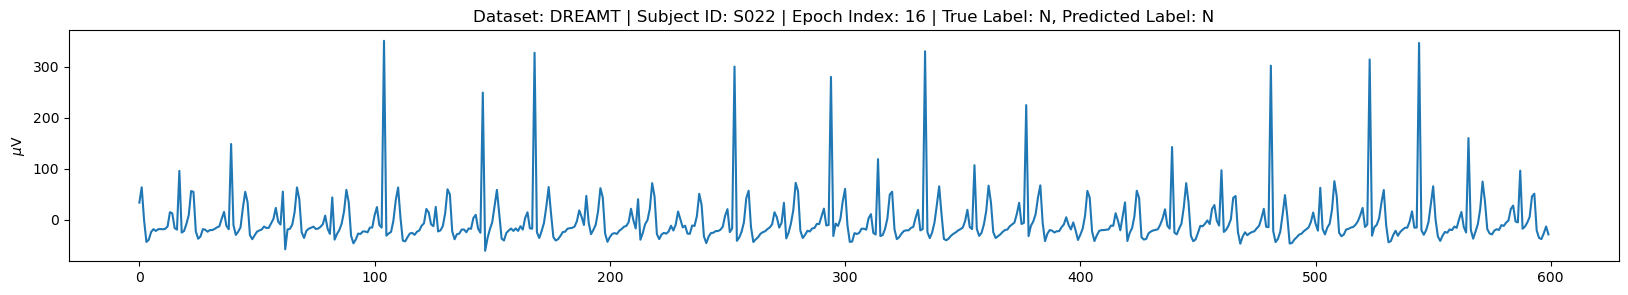

In [1117]:
rand_epoch_idx = random.randint(0, labels.shape[0]-1)
true_epoch_label = label_names[labels[rand_epoch_idx]]
pred_epoch_label = label_names[predicted_labels[rand_epoch_idx]]
epoch_signal = ecg[rand_epoch_idx, :]

plt.figure(figsize=(20, 3))
plt.plot(epoch_signal)
plt.title(f"Dataset: {DATASET} | Subject ID: {subject} | Epoch Index: {rand_epoch_idx} | True Label: {true_epoch_label}, Predicted Label: {pred_epoch_label}")
plt.ylabel(r"$\mu$V")